In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers 
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
import numpy as np
from google.colab import drive
import glob
import cv2 as cv
from google.colab.patches import cv2_imshow
import h5py
from tqdm import tqdm
from skimage.measure import compare_ssim as ssim
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Config:
  image_size = 33
  label_size = 21
  scale = 4
  stride = 14
  path_tr = "/content/drive/My Drive/Dataset/SR_training_datasets/T91/"
  path_test = "/content/drive/My Drive/Dataset/SR_testing_datasets/Set5/"

Dataset

for print images => cv2_imshow(img)

In [ ]:
def normalize(im):
  return im.astype(np.float) / 255
    
def modcrop(image):
  size = image.shape
  size -= np.mod(size, Config.scale)
  image = image[0:size[0], 0:size[1],0]
  return image

def modcrop_color(image):
  size = image.shape
  size -= np.mod(size, Config.scale)
  image = image[0:size[0], 0:size[1], :]
  return image

def unNormalize(imgs):
  imgs = imgs * 255
  imgs[imgs > 255] = 255
  imgs[imgs < 0] = 0
  return imgs.astype(np.uint8)

def read_data_training(name):
  file = Config.path_tr + name
  with h5py.File(file, 'r') as hf:
    data = np.array(hf.get('data'))
    label = np.array(hf.get('label'))
    return data, label

def prepare_images_training(path):
  label = []
  input = []

  for file in tqdm(glob.glob(path + "*.bmp")):
    img = cv.imread(file)
    #print(img.shape)
    label_ = normalize(modcrop(cv.cvtColor(img, cv.COLOR_BGR2YCR_CB)))
    #cv2_imshow(img)
    bicbuic_img = cv.resize(label_, None, fx = 1.0/Config.scale ,fy = 1.0/Config.scale, interpolation = cv.INTER_CUBIC)# Resize by scaling factor
    input_ = cv.resize(bicbuic_img, None, fx = Config.scale ,fy = Config.scale, interpolation = cv.INTER_CUBIC)# Resize by scaling factor
    
    input.append(input_)
    label.append(label_)

  return input, label

def make_sub_data(input_array, label_array):
  sub_input_sequence = []
  sub_label_sequence = []

  padding = int(abs(Config.image_size - Config.label_size) // 2)

  for i in tqdm(range(len(input_array))):
    h, w = input_array[i].shape

    input = input_array[i]
    label = label_array[i]

    for x in range(0, h - Config.image_size, Config.stride):
      for y in range(0, w - Config.image_size, Config.stride):
        sub_input = input[x : x + Config.image_size, y : y + Config.image_size] # [33 x 33]
        sub_label = label[x + padding : x + padding + Config.label_size, y + padding : y + padding + Config.label_size] # [21 x 21]
        sub_input = sub_input.reshape((Config.image_size, Config.image_size, 1)) 
        sub_label = sub_label.reshape([Config.label_size, Config.label_size, 1])

        
        sub_input_sequence.append(sub_input)
        sub_label_sequence.append(sub_label)

  return sub_input_sequence, sub_label_sequence

def compare_images(target, ref):
  scores = []
  scores.append(psnr(target, ref))
  scores.append(mse(target, ref))
  scores.append(ssim(target, ref, multichannel =True))
  return scores

def psnr(target, ref):
  target_data = target.astype(float)
  ref_data = ref.astype(float)

  diff = ref_data - target_data
  diff = diff.flatten('C')

  rmse = math.sqrt(np.mean(diff ** 2.))

  return 20 * math.log10(255. / rmse)

def mse(target, ref):
  err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
  err /= float(target.shape[0] * target.shape[1])
  return err

def shave(image, border):
  img = image[border: -border, border: -border]
  return img

In [ ]:
input_, label_ = prepare_images_training(Config.path_tr)
train, validate = np.split(input_, [int(len(input_)*0.8)])
train_label, validate_label = np.split(label_, [int(len(label_)*0.8)])

input, label = make_sub_data(train, train_label)
input_validate, label_validate = make_sub_data(validate, validate_label)

with h5py.File(Config.path_tr + "train.h5", 'w') as hf:
    hf.create_dataset('data', data = input)
    hf.create_dataset('label', data = label)

with h5py.File(Config.path_tr + "validation.h5", 'w') as hf:
    hf.create_dataset('data', data = input_validate)
    hf.create_dataset('label', data = label_validate)
    


100%|██████████| 19/19 [00:00<00:00, 1308.20it/s]


In [ ]:
input, label = read_data_training("train.h5")
input_val, label_val = read_data_training("validation.h5")

MODELLI

In [ ]:
srcnn = models.Sequential()
srcnn.add(layers.Conv2D(filters=64, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))

srcnn.add(layers.Conv2D(filters=32, kernel_size = (1, 1), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(5, 5, 64)))

srcnn.add(layers.Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True, input_shape=(5, 5, 32)))

srcnn.compile(optimizer = optimizers.Adam(lr=0.0003), loss='mean_squared_error', metrics=['mean_squared_error'])

In [ ]:
srcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 64)    5248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 1)     801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
srcnn.compile(optimizer=Adam(lr=0.001),
                     loss='mean_squared_error',
                     metrics=['mean_squared_error'])

history = srcnn.fit(input, label, epochs = 400, batch_size = 256,
                    validation_data=(input_val, label_val))

Epoch 1/400
63/63 [==============================] - 1s 13ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 2/400
63/63 [==============================] - 1s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 3/400
63/63 [==============================] - 1s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/400
63/63 [==============================] - 1s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 5/400
63/63 [==============================] - 1s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 6/400
63/63 [==============================] - 1s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 7/400
63/63 [==============

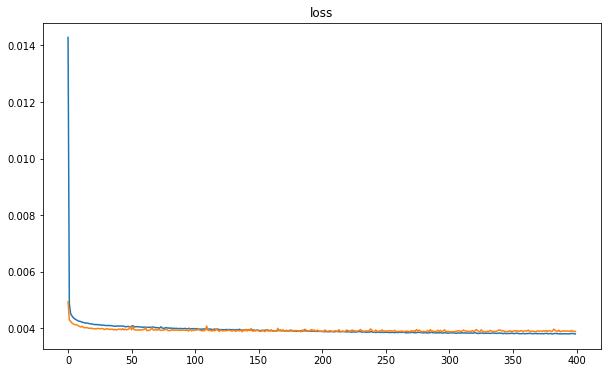

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')


plot_loss(history)

In [ ]:
print(len(input), len(label),len(input_val),len(label_val))

16024 16024 5688 5688


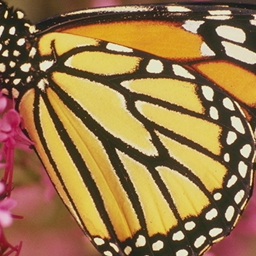

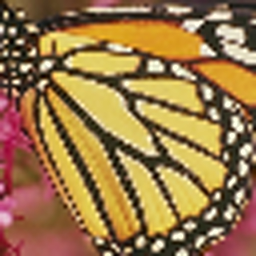

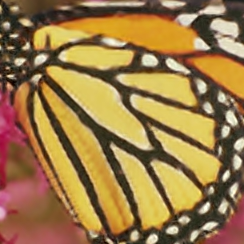

In [ ]:
for idx, file in enumerate(glob.glob(Config.path_test + "*.bmp")):
  img = cv.imread(file)
  gt_img = modcrop_color(cv.cvtColor(img, cv.COLOR_BGR2YCR_CB))
  lr_img = cv.resize(gt_img, None, fx = 1.0/Config.scale ,fy = 1.0/Config.scale, interpolation = cv.INTER_CUBIC)# Resize by scaling factor
  ilr_img = cv.resize(lr_img, None, fx = Config.scale ,fy = Config.scale, interpolation = cv.INTER_CUBIC)# Resize by scaling factor
  cv2_imshow(cv.cvtColor(gt_img, cv.COLOR_YCR_CB2BGR))
  cv2_imshow(cv.cvtColor(ilr_img, cv.COLOR_YCR_CB2BGR))
  Y = np.zeros((1, ilr_img.shape[0], ilr_img.shape[1], 1), dtype=float)
  Y[0,:,:,0] = normalize(ilr_img[:,:,0])
  prediction = srcnn.predict(Y, batch_size=1)
    #Image Reconstruction
  ilr_img = shave(ilr_img, 6)
  ilr_img[:,:,0] = unNormalize(prediction[0, :, :, 0])
  cv2_imshow(cv.cvtColor(ilr_img, cv.COLOR_YCR_CB2BGR)) 
  break

In [ ]:
sum_bic_psnr = 0
sum_srcnn_psnr = 0
sum_bic_ssim = 0
sum_srcnn_ssim = 0
sum_bic_mse = 0
sum_srcnn_mse = 0
num = 0
for idx, file in enumerate(glob.glob(Config.path_test + "*.bmp")):
  # Read and create images
  img = cv.imread(file)
  gt_img = modcrop_color(cv.cvtColor(img, cv.COLOR_BGR2YCR_CB))
  lr_img = cv.resize(gt_img, None, fx = 1.0/Config.scale ,fy = 1.0/Config.scale, interpolation = cv.INTER_CUBIC)# Resize by scaling factor
  ilr_img = cv.resize(lr_img, None, fx = Config.scale ,fy = Config.scale, interpolation = cv.INTER_CUBIC)# Resize by scaling factor

  #Evaluation bicubic image
  sum_bic_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_bic_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0],  multichannel=True)
  sum_bic_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])

  #Prediction
  Y = np.zeros((1, ilr_img.shape[0], ilr_img.shape[1], 1), dtype=float)
  Y[0,:,:,0] = normalize(ilr_img[:,:,0])
  prediction = srcnn.predict(Y, batch_size=1)

  #Image Reconstruction
  ilr_img = shave(ilr_img, 6)
  ilr_img[:,:,0] = unNormalize(prediction[0, :, :, 0])

  #Evaluation fsrcnn output
  gt_img = shave(gt_img, 6)
  sum_srcnn_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_srcnn_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0], multichannel=True)
  sum_srcnn_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])
  
  num += 1

print("PSNR Bicubic: ", sum_bic_psnr/num)
print("PSNR SRCNN: ", sum_srcnn_psnr/num)
print("\n")
print("SSIM Bicubic: ", sum_bic_ssim/num)
print("SSIM SRCNN: ", sum_srcnn_ssim/num)
print("\n")
print("MSE Bicubic: ", sum_bic_mse/num)
print("MSE SRCNN: ", sum_srcnn_mse/num)

PSNR Bicubic:  26.3329123210167
PSNR SRCNN:  26.971716679110774


SSIM Bicubic:  0.7715630906756042
SSIM SRCNN:  0.7906343023267576


MSE Bicubic:  227.5090933772551
MSE SRCNN:  185.74879981583177
